In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint


c:\Users\doren\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Import daily prices of the S&P 50 and filter the data to include only the 2019-2024 period
prices = pd.read_excel('SP500 for Code.xlsx', sheet_name='SP50 2015', index_col=0, parse_dates=True)
prices = prices.loc['2019-12-31':'2024-10-15']

# Calculate the daily returns of the S&P 50
returns = prices.pct_change().dropna()
returns = returns[returns.sum(axis=1) != 0]

returns.head()

,APPLE,NVIDIA,MICROSOFT,AMAZON.COM,META PLATFORMS A,ALPHABET 'A',ELI LILLY,BROADCOM,TESLA,WALMART,...,CATERPILLAR,DANAHER,S&P GLOBAL,SERVICENOW,TEXAS INSTRUMENTS,PHILIP MORRIS INTL.,WALT DISNEY,QUALCOMM,MORGAN STANLEY,PFIZER
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,0.022816,0.019584,0.018516,0.027151,0.022071,0.021868,0.005935,0.020157,0.028517,0.000843,...,0.019298,0.010620,0.017543,0.031595,0.009977,0.001175,0.024684,0.005214,0.017997,-0.001020
2020-01-03,-0.009722,-0.016006,-0.012452,-0.012139,-0.005291,-0.005231,-0.003328,-0.025435,0.029633,-0.008828,...,-0.013884,-0.006190,-0.003348,-0.000480,-0.013275,-0.001878,-0.011471,-0.018830,-0.016141,-0.005363
2020-01-06,0.007968,0.004202,0.002585,0.014886,0.018834,0.026654,0.003719,-0.001496,0.019256,-0.002036,...,-0.000674,0.002985,0.007692,0.006080,-0.006961,0.011643,-0.005802,-0.005861,-0.003516,-0.001284
2020-01-07,-0.004703,0.012098,-0.009118,0.002092,0.002164,-0.001932,0.001890,-0.003443,0.038797,-0.009266,...,-0.013213,0.009831,0.006952,0.000136,0.019297,0.004418,0.000343,0.028436,-0.001960,-0.003345
2020-01-08,0.016086,0.001884,0.015928,-0.007809,0.010138,0.007118,0.009056,-0.012474,0.049206,-0.003431,...,0.008881,0.001025,0.014343,0.009354,0.002705,0.018981,-0.002059,-0.002922,0.012765,0.008001


In [3]:
monthly_returns = prices.resample('M').last().pct_change().dropna()

C:\Users\doren\AppData\Local\Temp\ipykernel_19512\3749952209.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = prices.resample('M').last().pct_change().dropna()


In [4]:
# Input parameters
n = prices.shape[1] # number of assets

mu = returns.mean().values * 252 # annualized expected returns

vol = returns.std().values * np.sqrt(252) # annualized volatilities

correl_matrix = returns.corr().values # correlation matrix

x0 = np.ones(n) / n # initial weights

covmat = vol.reshape(1,-1) * correl_matrix * vol.reshape(-1,1) # covariance matrix

In [40]:
# Define the quadratic programming objective function
def QP(x, sigma, mu, gamma):
    return 0.5 * x.T @ sigma @ x - gamma * x.T @ mu

weight_sum_constraint = LinearConstraint(np.ones(x0.shape), lb=1, ub=1)

bounds_noshort = [(0, 1) for _ in range(n)]  # No short-selling, all weights between 0 and 1

# Efficient frontier function
# On pourra réutiliser cette fonction en y ajoutant les constraints et les bounds de notre choix.
def efficient_frontier(gam, covmat, constraint, mu, bounds):

    # Minimization with the defined constraint and bounds
    res = minimize(QP, x0, args=(covmat, mu, gam), 
                   bounds=bounds, constraints=constraint, 
                   options={'disp': False})
    
    optimized_weights = res.x
    mu_optimized = optimized_weights @ mu
    vol_optimized = np.sqrt(optimized_weights @ covmat @ optimized_weights)
    
    return mu_optimized, vol_optimized, optimized_weights

In [41]:
x1 = efficient_frontier(0.25, covmat, weight_sum_constraint, mu, bounds_noshort)[2]
x2 = efficient_frontier(0., covmat, weight_sum_constraint, mu, bounds_noshort)[2]

alpha_star = x1[-1] / (x1[-1] - x2[-1])
tangency_port = (1-alpha_star) * x1 + alpha_star * x2

tangency_mu = tangency_port @ mu
tangency_vol = np.sqrt(tangency_port @ covmat @ tangency_port)

tangency_mu, tangency_vol

(np.float64(0.6115372313279551), np.float64(0.33525066478268756))

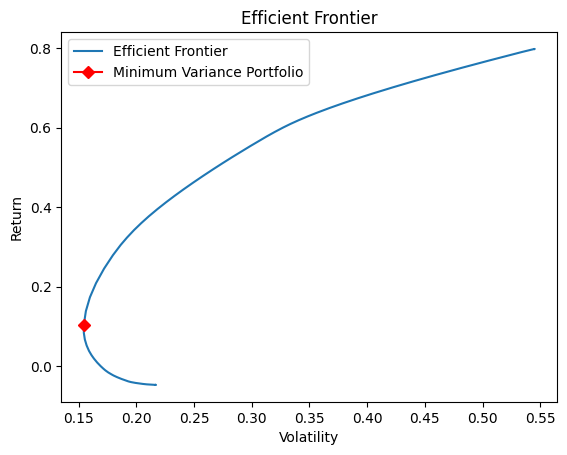

In [42]:
mu_efficient_frontier = []
vol_efficient_frontier = []
weights_efficient_frontier = []

# Define a range of gamma values
gammas = np.linspace(-2, 2, 500)

for gam in gammas:
    mu_optimized, vol_optimized, optimized_weights = efficient_frontier(gam, covmat, weight_sum_constraint, mu, bounds_noshort)
    mu_efficient_frontier.append(mu_optimized)
    vol_efficient_frontier.append(vol_optimized)
    weights_efficient_frontier.append(optimized_weights)

# Index of the gamma = 0 (minimum variance portfolio)
gamma_zero_index = np.argmin(np.abs(gammas))


# Plot efficient frontier
plt.plot(vol_efficient_frontier, mu_efficient_frontier, label='Efficient Frontier')
plt.plot(vol_efficient_frontier[gamma_zero_index], mu_efficient_frontier[gamma_zero_index], color='r', marker='D', label='Minimum Variance Portfolio')
plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.legend()
plt.show()

In [5]:
class EfficientFrontier:
    '''
    This class implements the Markowitz Efficient Frontier.
    '''
    def __init__(self, prices, risk_free_rate=None, short=False):
        '''
        Initialize the EfficientFrontier object.
        Compute the expected returns, volatilities, correlation matrix and covariance matrix.
        '''
        self.prices = prices  # DataFrame with historical prices
        self.risk_free_rate = risk_free_rate  # Risk-free rate
        self.returns = prices.pct_change().dropna()  # Compute returns
        self.returns = self.returns[self.returns.sum(axis=1) != 0]  # Remove days with zero returns
        self.short = short  # Short-selling allowed or not

        # Compute returns and covariances for the risky assets
        self.mu = self.returns.mean().values * 252  # Annualized expected returns
        self.vol = self.returns.std().values * np.sqrt(252)  # Annualized volatilities
        self.correl_matrix = self.returns.corr().values  # Correlation matrix
        self.covmat = self.vol.reshape(1, -1) * self.correl_matrix * self.vol.reshape(-1, 1)  # Covariance matrix
        self.n = self.mu.shape[0]
        self.x0 = np.ones(self.n) / self.n

        # If a risk-free rate is provided, modify the mu, vol, and covmat
        if risk_free_rate is not None:
            self.mu_mod = np.append(self.mu, self.risk_free_rate)  # Append risk-free rate to the expected returns
            self.vol_mod = np.append(self.vol, 0)
            self.covmat_mod = np.zeros((self.n+1, self.n+1))
            self.covmat_mod[:self.n, :self.n] = self.covmat
            self.x0_mod = np.ones(self.n+1) / (self.n+1)
            self.SR = (self.mu - self.risk_free_rate) / self.vol
        else:
            self.mu_mod = None
            self.vol_mod = None
            self.covmat_mod = None
            self.x0_mod = None
            self.SR = self.mu / self.vol


    def QP(self, x, sigma, mu, gamma):
        '''
        Standard QP problem function.
        Maximize utility by minimizing variance for a given return target (gamma).
        '''
        return 0.5 * x.T @ sigma @ x - gamma * x.T @ mu

    def efficient_frontier(self, n, x0, covmat, mu, gam):
        '''
        Compute the efficient frontier for a given gamma.
        We need to give the constraints and bounds to the optimizer.
        '''
        constraints = LinearConstraint(np.ones(n), lb=1, ub=1)  # Adjust constraints
        if self.short:
            bounds = [(None, None) for _ in range(n)]  # Short-selling allowed
        else:
            bounds = [(0, 1) for _ in range(n)]  # No short-selling allowed

        res = minimize(self.QP, x0, args=(covmat, mu, gam),
                    bounds=bounds, constraints=constraints)

        optimized_weights = res.x
        mu_optimized = optimized_weights @ mu
        vol_optimized = np.sqrt(optimized_weights @ covmat @ optimized_weights)

        return mu_optimized, vol_optimized, optimized_weights
    
    def plot_efficient_frontier(self):
        '''
        Plot the efficient frontier.
        '''
        gammas = np.linspace(-5, 5, 500)  # Range of gamma values for the efficient frontier

        # Compute efficient frontier for risky assets
        frontier1 = [self.efficient_frontier(self.n, self.x0, self.covmat, self.mu, g) for g in gammas]

        # Plot for risky assets only
        gamma_zero_index = np.argmin(np.abs(gammas))
        plt.plot([f[1] for f in frontier1], [f[0] for f in frontier1], '-', label="Efficient Frontier")
        plt.plot(frontier1[gamma_zero_index][1], frontier1[gamma_zero_index][0], color='r', marker='D', label='Minimum Variance Portfolio')

        # If risk-free rate is provided, compute and plot the extended frontier
        if self.risk_free_rate is not None:
            maxvalue = 1
            it = 100
            gammas2 = np.linspace(0, maxvalue, it)
            frontier2 = [self.efficient_frontier(self.n + 1, self.x0_mod, self.covmat_mod, self.mu_mod, g) for g in gammas2]

            # Compute the tangency portfolio by combining two arbitrary portfolios
            x1_pos = round(0.25/maxvalue * (it-1), 0) # Position of the portfolio with gamma = 0.25
            x2_pos = round(0.5/maxvalue * (it-1), 0) # Position of the portfolio with gamma = 0.5
            x1 = frontier2[int(x1_pos)][2] # Weights of the portfolio with gamma = 0.25
            x2 = frontier2[int(x2_pos)][2] # Weights of the portfolio with gamma = 0.5

            alpha_star = x1[-1] / (x1[-1] - x2[-1])
            tangency_pf = (1-alpha_star) * x1 + alpha_star * x2

            tangency_mu = tangency_pf @ self.mu_mod
            tangency_vol = np.sqrt(tangency_pf @ self.covmat_mod @ tangency_pf)

            plt.plot([f[1] for f in frontier2], [f[0] for f in frontier2], '--', label="Capital Market Line")
            plt.plot(tangency_vol, tangency_mu, color='g', marker='*', label='Tangency Portfolio', markersize=10)

        plt.title(f'Efficient Frontier - Short-selling: {self.short} - Risk-free rate: {self.risk_free_rate}')
        plt.xlabel('Volatility')
        plt.ylabel('Return')

        if self.short is False:
            plt.ylim(-0.5, 1)
            plt.xlim(0, 0.8)
        else:
            plt.ylim(-4, 9)
            plt.xlim(0, 2.25)
        plt.legend()
        plt.show()


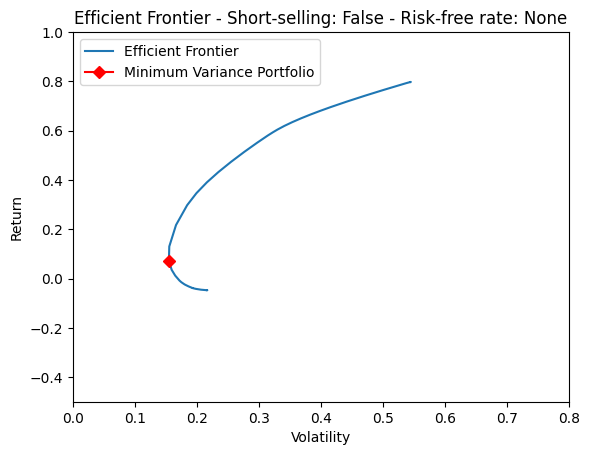

In [6]:
ef = EfficientFrontier(prices, risk_free_rate=None, short=False)
ef.plot_efficient_frontier()

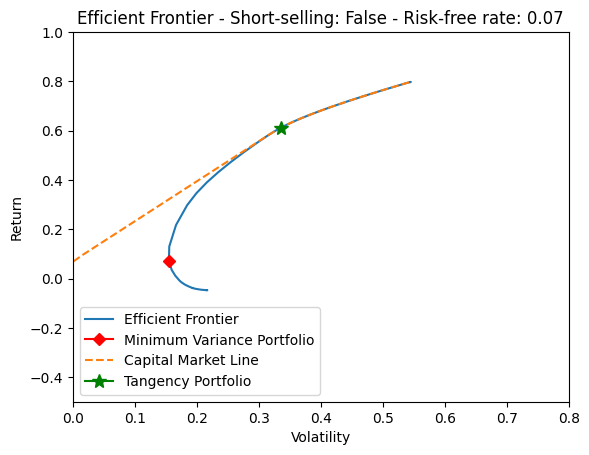

In [7]:
ef = EfficientFrontier(prices, risk_free_rate=0.07, short=False)
ef.plot_efficient_frontier()

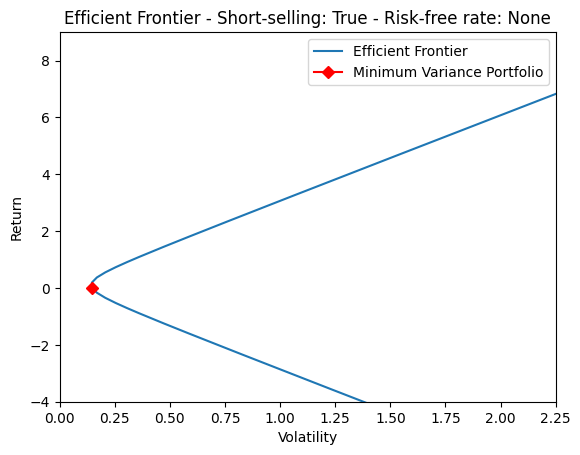

In [8]:
ef = EfficientFrontier(prices, risk_free_rate=None, short=True)
ef.plot_efficient_frontier()

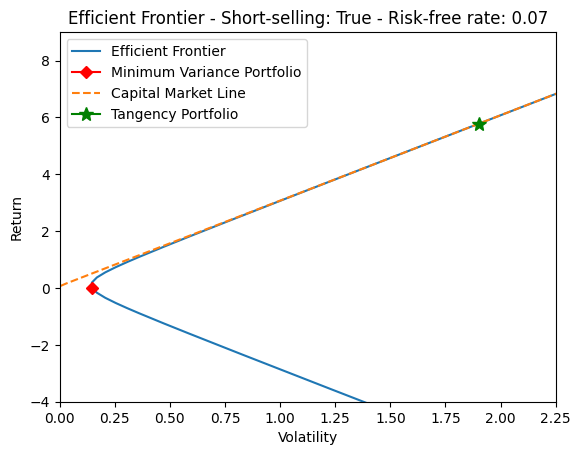

In [9]:
ef = EfficientFrontier(prices, risk_free_rate=0.07, short=True)
ef.plot_efficient_frontier()

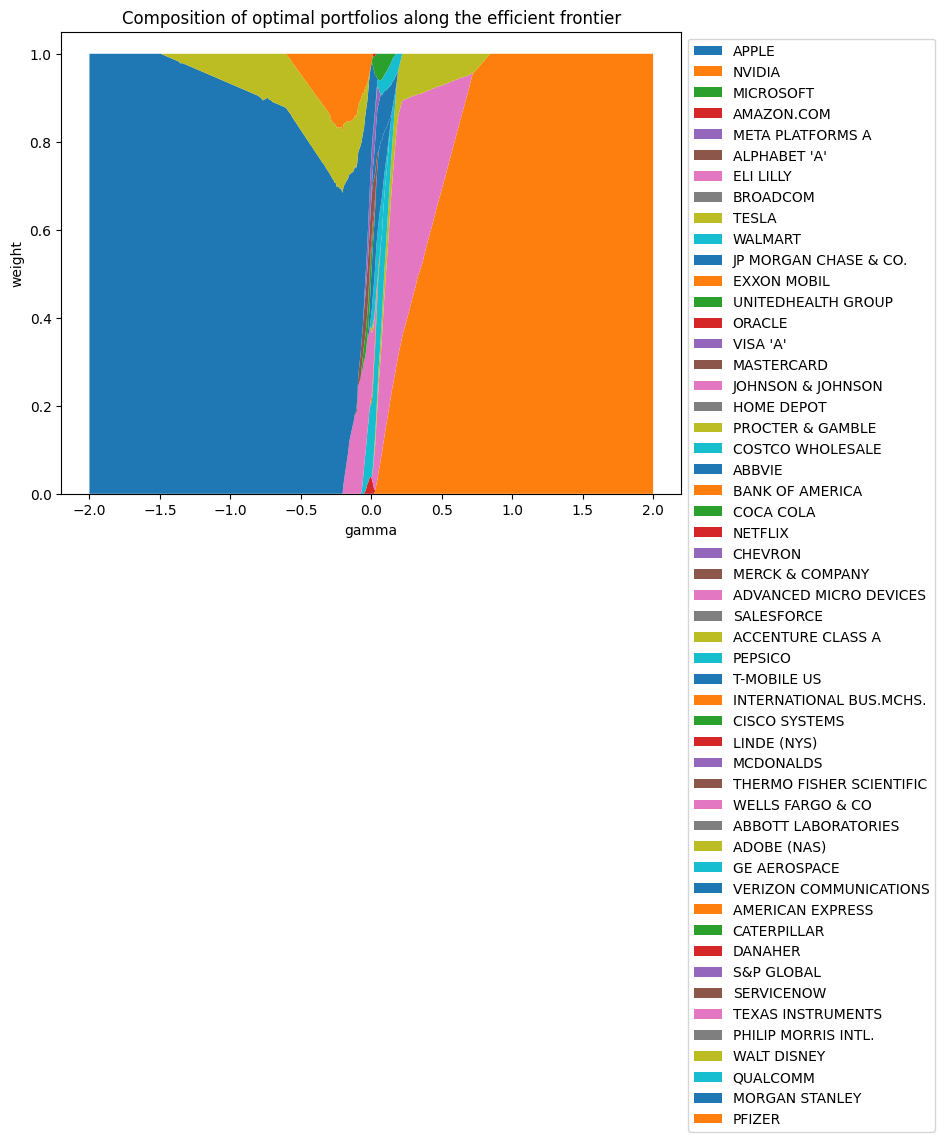

In [48]:
# resampling

data_composition_map = pd.DataFrame(weights_efficient_frontier, columns=prices.columns, index=np.linspace(-2, 2, 500))

fig, ax = plt.subplots(figsize=(8, 6))
ax.stackplot(data_composition_map.index, data_composition_map.T.values, labels=data_composition_map.columns)
ax.set_title('Composition of optimal portfolios along the efficient frontier')
ax.set_ylabel('weight')
ax.set_xlabel('gamma')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [49]:
all_weights = pd.DataFrame(columns = prices.columns)

for i in range(50):
    simulated_r = np.random.multivariate_normal(mu, covmat, 100)
    simulated_mu = np.mean(simulated_r, axis = 0)
    simulated_cov_mat = np.cov(simulated_r, rowvar = False)
    
    weights_efficient_frontier = []
    
    for gam in np.linspace(-0.5,1.5,101):
        weights_efficient_frontier.append(efficient_frontier(gam, simulated_cov_mat, weight_sum_constraint, simulated_mu, bounds_noshort)[2])
        
    to_append = pd.DataFrame(weights_efficient_frontier, columns = prices.columns)
    to_append['gamma'] = np.linspace(-0.5,1.5,101)

    all_weights = pd.concat([all_weights, to_append], ignore_index = True)

/var/folders/dj/3wx6qp3d3v31b81648wbyc5w0000gp/T/ipykernel_18883/244841154.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_weights = pd.concat([all_weights, to_append], ignore_index = True)


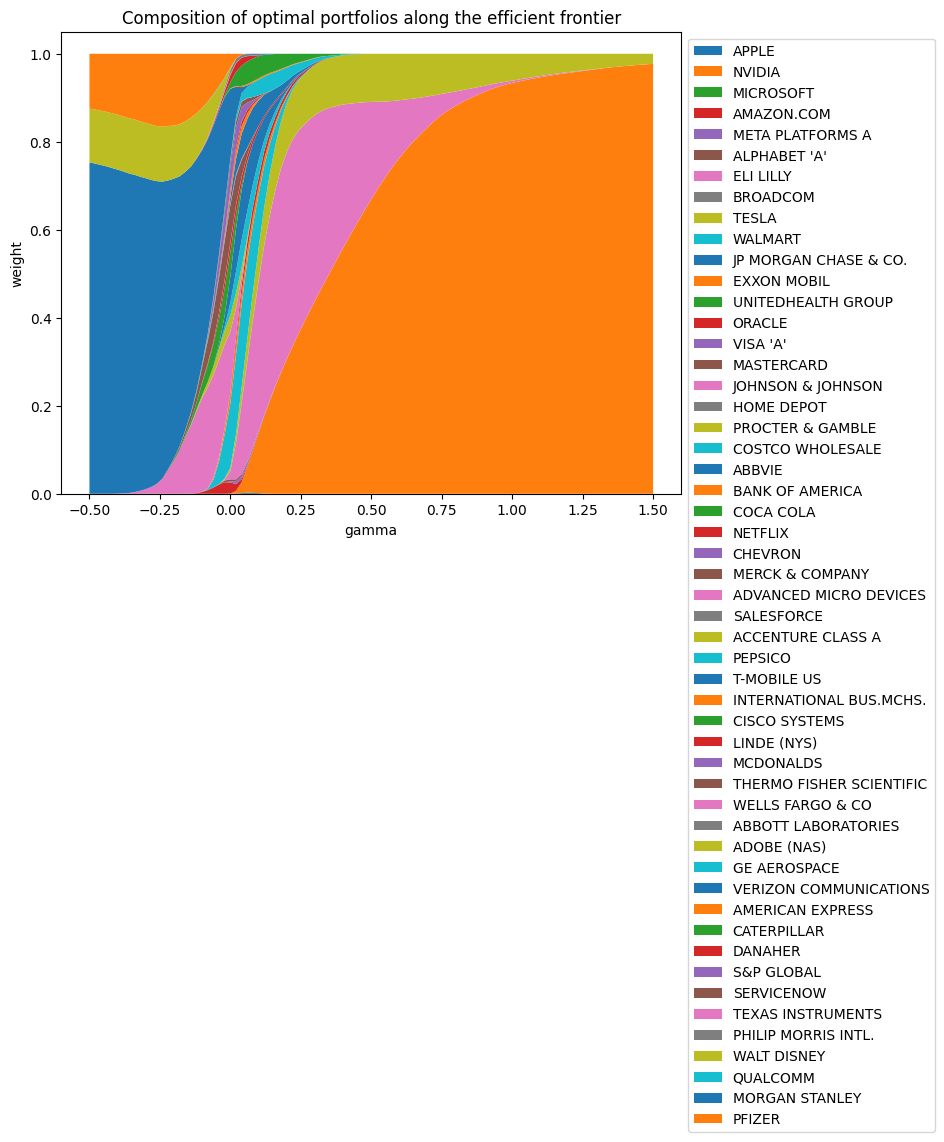

In [50]:
avg_weights = all_weights.groupby(by='gamma').mean()
avg_weights.sum(axis=1)

data_composition_map2 = pd.DataFrame(avg_weights, columns = prices.columns, index = np.linspace(-0.5,1.5,101))

fig, ax = plt.subplots(figsize=(8, 6))
ax.stackplot(data_composition_map2.index, data_composition_map2.T.values, labels=data_composition_map2.columns)
ax.set_title('Composition of optimal portfolios along the efficient frontier')
ax.set_ylabel('weight')
ax.set_xlabel('gamma')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

## Risk Budgeting 

In [51]:
class Portfolio: 
    # Equal Risk Contribution Portfolio maybe use only one class and change the name to portfolio 
    def __init__(self, price, risk_free_rate=None, short=False):
        ''' Initialize the Equal Risk Contribution Portfolio object.'''
        self.prices = prices  # DataFrame with historical prices
        self.risk_free_rate = risk_free_rate  # Risk-free rate
        self.returns = prices.pct_change().dropna()  # Compute returns
        self.returns = self.returns[self.returns.sum(axis=1) != 0]  # Remove days with zero returns
        self.short = short  # Short-selling allowed or not

        # Compute returns and covariances for the risky assets
        self.mu = self.returns.mean().values * 252  # Annualized expected returns
        self.vol = self.returns.std().values * np.sqrt(252)  # Annualized volatilities
        self.correl_matrix = self.returns.corr().values  # Correlation matrix
        self.covmat = self.vol.reshape(1, -1) * self.correl_matrix * self.vol.reshape(-1, 1)  # Covariance matrix
        self.n = self.mu.shape[0]
        self.x0 = np.ones(self.n) / self.n

        # If a risk-free rate is provided, modify the mu, vol, and covmat
        if risk_free_rate is not None:
            self.mu_mod = np.append(self.mu, self.risk_free_rate)  # Append risk-free rate to the expected returns
            self.vol_mod = np.append(self.vol, 0)
            self.covmat_mod = np.zeros((self.n+1, self.n+1))
            self.covmat_mod[:self.n, :self.n] = self.covmat
            self.x0_mod = np.ones(self.n+1) / (self.n+1)
            self.SR = (self.mu - self.risk_free_rate) / self.vol
        else:
            self.mu_mod = None
            self.vol_mod = None
            self.covmat_mod = None
            self.x0_mod = None
            self.SR = self.mu / self.vol
    
    def EW(self):
        '''Compute the equally weighted portfolio.'''
        return np.ones(self.n) / self.n
    
    def ARC(self, x, sigma):
        '''Compute the risk contribution of each asset.'''
        return np.dot(sigma, x) * x / np.sqrt(np.dot(x, np.dot(sigma, x)))

    def RRC(self, x, sigma):
        '''Compute the average risk contribution of the portfolio.'''
        return np.dot(sigma, x) * x / np.dot(x, np.dot(sigma, x))

    def MRC(self, x, sigma):
        '''Compute the marginal risk contribution of each asset.'''
        return sigma @ x / np.sqrt(np.dot(x, np.dot(sigma, x)))

    def QP(self, x, sigma):
        '''Standard QP problem function.'''
        return 0.5 * x.T @ sigma @ x 

    def ERC(self, x, sigma):
        '''Compute the equal risk contribution portfolio.'''
        
        logy = lambda y: np.sum(np.log(y))
        constraints = [LinearConstraint(np.eye(x0.shape[0]), lb = 0, ub = 1), NonlinearConstraint(logy, lb = -n * np.log(n) - 2, ub=np.inf)]
        res = minimize(self.QP, x0, args=(self.covmat), constraints=constraints) 
        optimized_weights_erc = res.x / np.sum(res.x)

        return optimized_weights_erc

    def DR(self,x,vol,sigma):
        '''Compute the diversification ratio of the portfolio.'''
        return -np.log(x.T@vol / np.sqrt(x @ sigma @ x))
    def MDP(self):
        '''Compute the maximum diversification portfolio.'''
        constraints = [LinearConstraint(np.ones(x0.shape[0]), lb = 1, ub = 1)] #no long only see lecture6 for the reasons
        res = minimize(self.DR, self.x0, args=(self.vol,self.covmat), constraints=constraints)
        optimized_weights_mdp = res.x


        return optimized_weights_mdp


In [ ]:
portfolio_test = Portfolio(prices, risk_free_rate=None, short=False)
portfolio_test.EW()

array([0.01923077, 0.01923077, 0.01923077, 0.01923077, 0.01923077,
       0.01923077, 0.01923077, 0.01923077, 0.01923077, 0.01923077,
       0.01923077, 0.01923077, 0.01923077, 0.01923077, 0.01923077,
       0.01923077, 0.01923077, 0.01923077, 0.01923077, 0.01923077,
       0.01923077, 0.01923077, 0.01923077, 0.01923077, 0.01923077,
       0.01923077, 0.01923077, 0.01923077, 0.01923077, 0.01923077,
       0.01923077, 0.01923077, 0.01923077, 0.01923077, 0.01923077,
       0.01923077, 0.01923077, 0.01923077, 0.01923077, 0.01923077,
       0.01923077, 0.01923077, 0.01923077, 0.01923077, 0.01923077,
       0.01923077, 0.01923077, 0.01923077, 0.01923077, 0.01923077,
       0.01923077, 0.01923077])

In [53]:
optimized_weights_erc = portfolio_test.ERC(x0, covmat)
portfolio_test.ARC(optimized_weights_erc, covmat)

/var/folders/dj/3wx6qp3d3v31b81648wbyc5w0000gp/T/ipykernel_18883/3486089554.py:57: RuntimeWarning: invalid value encountered in log
  logy = lambda y: np.sum(np.log(y))


array([ 2.42956986e-03,  2.09374268e-18,  2.28150994e-03,  2.86033857e-03,
        9.48072658e-04,  2.68352893e-03,  5.75978412e-03,  7.97485708e-05,
       -6.96019086e-18,  5.23684211e-03,  3.19499529e-03,  4.82763035e-03,
        5.17716718e-03,  4.05138839e-03,  3.49030856e-03,  2.50604389e-03,
        5.73731692e-03,  3.76646142e-03,  5.73970784e-03,  4.86838066e-03,
        5.70886766e-03,  2.04388516e-03,  5.62041931e-03,  2.72983367e-03,
        3.90906674e-03,  5.73147637e-03, -3.79500592e-18,  1.42331143e-03,
        3.07384760e-03,  5.64585260e-03,  5.00199869e-03,  5.06429801e-03,
        4.41120943e-03,  4.28889392e-03,  5.07151085e-03,  4.76450989e-03,
        2.14916673e-03,  5.23064837e-03,  1.04036498e-03,  2.72935979e-03,
        5.38544663e-03,  8.34104346e-04,  4.17245173e-03,  4.58391940e-03,
        3.33063562e-03,  4.95830299e-04,  2.37132039e-03,  5.55978375e-03,
        3.19341263e-03,  1.18231963e-04,  1.40609161e-03,  5.89360523e-03])

In [54]:
portfolio_test.RRC(optimized_weights_erc, covmat)

array([ 1.36017278e-02,  1.17216296e-17,  1.27728277e-02,  1.60133476e-02,
        5.30769928e-03,  1.50234947e-02,  3.22456320e-02,  4.46465183e-04,
       -3.89660009e-17,  2.93179883e-02,  1.78868930e-02,  2.70270532e-02,
        2.89839036e-02,  2.26813326e-02,  1.95401777e-02,  1.40298608e-02,
        3.21198514e-02,  2.10861946e-02,  3.21332367e-02,  2.72551901e-02,
        3.19605808e-02,  1.14425067e-02,  3.14654107e-02,  1.52827276e-02,
        2.18845576e-02,  3.20871536e-02, -2.12459985e-17,  7.96828070e-03,
        1.72086586e-02,  3.16077967e-02,  2.80032386e-02,  2.83520157e-02,
        2.46957582e-02,  2.40109858e-02,  2.83923962e-02,  2.66736790e-02,
        1.20319161e-02,  2.92833132e-02,  5.82438954e-03,  1.52800747e-02,
        3.01499373e-02,  4.66965796e-03,  2.33590947e-02,  2.56626594e-02,
        1.86462632e-02,  2.77586122e-03,  1.32756233e-02,  3.11259480e-02,
        1.78780327e-02,  6.61910983e-04,  7.87187709e-03,  3.29948174e-02])

In [55]:
portfolio_test.MRC(optimized_weights_erc, covmat)

array([0.22355464, 0.29013473, 0.22568289, 0.18484137, 0.22695389,
       0.21055106, 0.17168949, 0.24553422, 0.2411224 , 0.1226038 ,
       0.23267697, 0.19217997, 0.20278528, 0.20141673, 0.21788638,
       0.23843119, 0.1386149 , 0.21401961, 0.149491  , 0.15704004,
       0.14833261, 0.25709728, 0.15694837, 0.18321156, 0.22412889,
       0.13835018, 0.26294134, 0.2251263 , 0.22566702, 0.16996139,
       0.16893537, 0.1860851 , 0.20318805, 0.20012251, 0.16642438,
       0.1805025 , 0.25382042, 0.18506829, 0.23448425, 0.23233434,
       0.12127618, 0.26723839, 0.20115298, 0.18690432, 0.22066255,
       0.23910043, 0.22334102, 0.17329105, 0.21217144, 0.24074387,
       0.26181807, 0.15458863])

In [56]:
MDP = portfolio_test.MDP()
np.round(MDP, 3)

array([-0.09 ,  0.034, -0.203,  0.038,  0.094, -0.022,  0.082,  0.002,
        0.092,  0.188,  0.016,  0.129,  0.043,  0.068, -0.101, -0.026,
        0.035, -0.051,  0.113, -0.052,  0.058, -0.106,  0.034,  0.066,
        0.003,  0.069,  0.047,  0.017, -0.078, -0.11 ,  0.067,  0.034,
       -0.041, -0.072,  0.1  ,  0.064,  0.074,  0.041,  0.048,  0.042,
        0.14 ,  0.041,  0.067,  0.001, -0.052,  0.047, -0.138,  0.008,
        0.023,  0.053, -0.059,  0.123])

# BLACK LITTERMAN

In [57]:
class BlackLitterman:
    def __init__(self, prices, risk_free_rate, short=False):
        ''' Initialize the Black-Litterman object.'''
        self.prices = prices  # DataFrame with historical prices
        self.risk_free_rate = risk_free_rate  # Risk-free rate
        self.returns = prices.pct_change().dropna()  # Compute returns
        self.returns = self.returns[self.returns.sum(axis=1) != 0]  # Remove days with zero returns
        self.short = short  # Short-selling allowed or not

        # Compute returns and covariances for the risky assets
        self.mu = self.returns.mean().values * 252  # Annualized expected returns
        self.vol = self.returns.std().values * np.sqrt(252)  # Annualized volatilities
        self.correl_matrix = self.returns.corr().values  # Correlation matrix
        self.covmat = self.vol.reshape(1, -1) * self.correl_matrix * self.vol.reshape(-1, 1)  # Covariance matrix
        self.n = self.mu.shape[0]
        self.x0 = np.ones(self.n) / self.n

        # If a risk-free rate is provided, modify the mu, vol, and covmat
        
        self.mu_mod = np.append(self.mu, self.risk_free_rate)  # Append risk-free rate to the expected returns
        self.vol_mod = np.append(self.vol, 0)
        self.covmat_mod = np.zeros((self.n+1, self.n+1))
        self.covmat_mod[:self.n, :self.n] = self.covmat
        self.x0_mod = np.ones(self.n+1) / (self.n+1)
        self.SR = (((self.mu - self.risk_free_rate) / self.vol)@ np.ones(self.n)) / self.n


        self.implied_mu = self.risk_free_rate + self.SR * (self.covmat_mod @ self.x0_mod) / np.sqrt(self.x0_mod @ self.covmat_mod @ self.x0_mod)
        self.P = None
        self.Q = None
        self.Omega = None
        self.tau = 0.05
        self.implied_phi = self.SR/self.vol_mod
    def QP(x, sigma, mu, gamma ):
    
        v = 0.5 * x.T @ sigma @ x - gamma * x.T @ mu
    
        return v

    def add_views(self, P, Q, Omega):
        '''Add views to the Black-Litterman model.'''

        if self.P is None:
            self.P = P
            self.Q = Q
            self.Omega = Omega
        else:
            self.P = np.vstack((self.P, P))
            self.Q = np.append(self.Q, Q)
            self.Omega = sp.linalg.block_diag(self.Omega, Omega)
    def gamma_matrix(self,tau):
        return tau * self.covmat_mod

    def target_tau(self, x_start, target_vol):
        '''Compute the target tau for the Black-Litterman model.'''
        mu_bar = self.implied_mu + (self.gamma_matrix(x) @ self.P.T) @ np.linalg.inv(self.P @ self.gamma_matrix(x) @ self.P.T + self.omega) @ (self.Q - self.P @ self.implied_mu)
        res = minimize(QP, x0, args = (self.covmat_mod, mu_bar, gam) , options={'disp': False}, constraints = constraints)
        optimized_weights = res.x
        return np.sqrt((optimized_weights-self.x0_mod) @ self.covmat_mod @ (optimized_weights-self.x0_mod)) - target_vol

    def optimal_tau(self):
        opti_tau = fsolve(target_tau, x_start = 0.05, args = 0.02)[0]
        return opti_tau

    def BL(self,tau):
        '''Compute the Black-Litterman portfolio.'''
        if self.P is None:
            raise ValueError('No views added to the model.')
        
        constraints = [LinearConstraint(np.ones(self.x0_mod.shape), ub = 1), 
               LinearConstraint(-np.ones(self.x0_mod.shape), ub = -1),
              LinearConstraint(np.eye(self.x0_mod.shape[0]), lb = 0)]

        mu_bar = self.implied_mu + (self.gamma_matrix(tau) @ self.P.T) @ np.linalg.inv(self.P @ self.gamma_matrix(tau) @ self.P.T + self.Omega) @ (self.Q - self.P @ self.implied_mu)
        gam = 1/self.implied_phi
        res = minimize(QP, self.x0_mod, args = (self.covmat_mod, mu_bar, gam) , options={'disp': False}, constraints = constraints)
        optimized_weights_bl = res.x
    
        return optimized_weights_bl
        

In [58]:
bl = BlackLitterman(prices, risk_free_rate=0.07, short=False)
# add a view using the prices dataframe 
P = np.zeros((1, 53))
P[0, 0] = 1
Q = 0.01
Omega = 0.01
bl.add_views(P, Q, Omega)

bl.BL(0.05)

/var/folders/dj/3wx6qp3d3v31b81648wbyc5w0000gp/T/ipykernel_18883/1793484212.py:33: RuntimeWarning: divide by zero encountered in divide
  self.implied_phi = self.SR/self.vol_mod


array([-1.47257013e-16,  2.28830610e-01, -1.78935479e-17,  2.31737288e-17,
        3.58821382e-02, -3.67976073e-17,  4.01021688e-17,  3.38434859e-17,
        2.31656748e-01, -4.12823715e-17,  1.67526280e-19, -7.56854305e-17,
       -2.82371313e-18, -6.27071584e-17, -2.20327201e-17, -2.74991120e-17,
        1.36259657e-17,  7.91257432e-18, -3.31423873e-18,  2.31370799e-18,
       -3.63261356e-17, -9.81889342e-17, -3.51520609e-17,  1.41527063e-02,
        4.32006650e-02, -2.31372369e-17,  1.16984183e-01, -5.35444818e-17,
       -3.21827675e-17, -6.64664067e-18, -2.26907927e-17, -5.99604179e-17,
       -6.19893750e-17, -5.05193405e-17,  3.12334046e-17, -1.26268017e-17,
        2.08678685e-01, -5.97931696e-17,  1.84949937e-17,  9.14198234e-02,
       -4.95120132e-17,  2.91944411e-02, -3.79491189e-17, -6.83363193e-17,
       -1.29099589e-17, -7.64025082e-17,  8.43760406e-18, -6.11410565e-18,
       -2.24724530e-17,  1.56648179e-17, -7.84586304e-17, -5.48494028e-17,
        1.57415886e-17])

In [82]:
def show_performance(prices, weights):
    '''Show the performance of the portfolio with a graph across time.'''
    # Compute the returns of the portfolio
    returns = prices.pct_change().dropna()
    returns = returns[returns.sum(axis=1) != 0]
    returns = returns @ weights
    returns = returns + 1
    returns = returns.cumprod()
    return returns

def max_drawdown(prices,weights):
    '''Compute the maximum drawdown of the portfolio.'''
    returns = prices.pct_change().dropna()
    returns = returns[returns.sum(axis=1) != 0]
    returns = returns @ weights
    returns = returns + 1
    returns = returns.cumprod()
    roll_max = returns.cummax()
    drawdown = returns / roll_max - 1.0
    max_drawdown = drawdown.min()
    return max_drawdown

In [84]:
returns = show_performance(prices, portfolio_test.EW())

<Axes: xlabel='Date'>

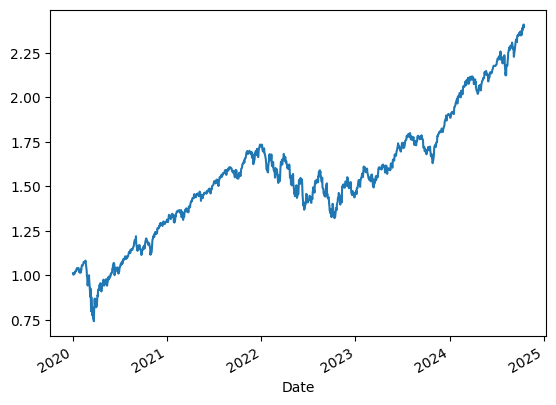

In [85]:
returns.plot()

In [89]:
max_drawdown(prices, optimized_weights_erc)

np.float64(-0.2802499969855622)